In [2]:
import pandas as pd
import numpy as np
import cmrl
from emei.core import get_params_str
from pathlib import Path
import matplotlib.pyplot as plt
import yaml
from collections import defaultdict

In [31]:
# 递归判断a字典中存在的值是否与b字典相等
def dict_equal(a, b):
    for k, v in a.items():
        if isinstance(v, dict):
            if not dict_equal(v, b[k]):
                return False
        elif v != b[k]:
            return False
    return True


def get_value(d, key):
    if isinstance(key, str):
        if key not in d:
            raise ValueError(f"{key} not in dict")
        return d[key]
    elif isinstance(key, tuple):
        if key[0] not in d:
            raise ValueError(f"{key[0]} not in dict")
        if len(key) <= 1:
            raise ValueError("length of tuple-key must be 2")
        return get_value(d[key[0]], key[1])
    else:
        raise ValueError("key must be str or tuple")


# 返回多个字典中不同的value对应的key, 通过递归的方法
def get_diff_key(dicts):
    if len(dicts) <= 1:
        return []
    keys = set(dicts[0].keys())
    for d in dicts[1:]:
        keys = keys & set(d.keys())

    diff_keys = []
    for k in keys:
        if isinstance(dicts[0][k], dict):
            diff_keys += [(k, dk) for dk in get_diff_key([d[k] for d in dicts])]
        elif not all([dicts[0][k] == d[k] for d in dicts[1:]]):
            diff_keys.append(k)
    return diff_keys


def argmax(l):
    return max(l), l.index(max(l))

In [21]:
default_params = dict(freq_rate=1,
                      real_time_scale=0.02,
                      integrator="euler",
                      parallel_num=3)
default_custom_cfg = {}
default_result_key = ["seed"]


def load_log(exp_name="default",
             task_name="ParallelContinuousCartPoleSwingUp-v0",
             params=default_params,
             dataset="SAC-expert-replay",
             custom_cfg=default_custom_cfg,
             log_file="rollout.csv",
             log_key="ep_rew_mean"):
    path = Path("./exp") / exp_name / task_name / get_params_str(params) / dataset

    result_list = []
    cfg_list = []
    for time_dir in path.glob(r"*"):
        if not time_dir.is_dir() or not (time_dir / ".hydra").exists():
            continue

        config_path = time_dir / ".hydra" / "config.yaml"
        with open(config_path, "r") as f:
            cfg = yaml.load(f, Loader=yaml.FullLoader)

        if not dict_equal(custom_cfg, cfg):
            print("{} is passed cause its inconsistent cfg".format(time_dir))
            continue

        log_path = time_dir / "log" / log_file
        if not log_path.exists():
            continue

        df = pd.read_csv(log_path)
        result_list.append(df[log_key].to_numpy())
        cfg_list.append(cfg)

    diff_key = get_diff_key(cfg_list)
    result_dict = {}
    for i, cfg in enumerate(cfg_list):
        result_dict[tuple([get_value(cfg, key) for key in diff_key])] = result_list[i]
    return diff_key, result_dict

In [33]:
def draw_result(exp_name="default",
                task_name="ParallelContinuousCartPoleSwingUp-v0",
                params=default_params,
                dataset="SAC-expert-replay",
                custom_cfg=default_custom_cfg,
                log_file="rollout.csv",
                log_key="ep_rew_mean",
                group_key=('transition', 'oracle')):
    diff_key, result_dict = load_log(exp_name=exp_name,
                                     task_name=task_name,
                                     params=params,
                                     dataset=dataset,
                                     custom_cfg=custom_cfg,
                                     log_file=log_file,
                                     log_key=log_key)

    idx = diff_key.index(group_key)

    for name in set([key[idx] for key in result_dict.keys()]):
        values = [value for key, value in result_dict.items() if key[idx] == name]
        longest, longest_idx = argmax([value.shape[0] for value in values])
        values_array = np.empty((len(values), longest))
        for i, value in enumerate(values):
            values_array[i, :len(value)] = value
            values_array[i, len(value):] = values[longest_idx][len(value):]
        plt.plot(values_array.mean(axis=0), label=name)
        plt.fill_between(np.arange(len(values_array.mean(axis=0))),
                         values_array.mean(axis=0) - values_array.std(axis=0),
                         values_array.mean(axis=0) + values_array.std(axis=0), alpha=0.5)
        plt.legend()

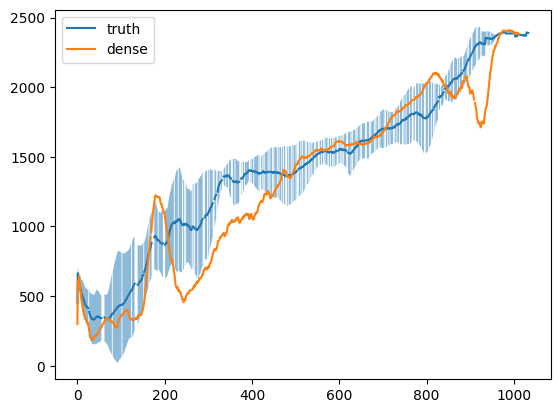

In [35]:
draw_result(
    task_name="ParallelContinuousCartPoleSwingUp-v0",
    log_file="rollout.csv",
    log_key="ep_rew_mean",
    params=dict(freq_rate=1,
                real_time_scale=0.02,
                integrator="euler",
                parallel_num=3),
    group_key=('transition', 'oracle'),
)

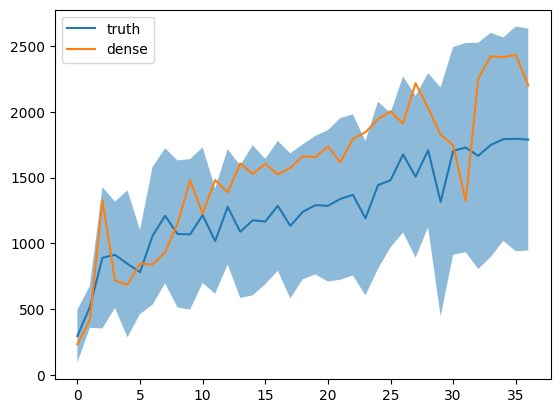

In [37]:
draw_result(
    task_name="ParallelContinuousCartPoleSwingUp-v0",
    log_file="eval.csv",
    log_key="mean_reward",
    params=dict(freq_rate=1,
                real_time_scale=0.02,
                integrator="euler",
                parallel_num=3),
    group_key=('transition', 'oracle'),
)